##DS Challenge
04/21/2021



In [ ]:
#select GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
#connect to drive
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [84]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import pickle
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import sklearn.feature_extraction.text as text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score


Data preprocessing

In [21]:
#load data
path = "drive/MyDrive/Eluvio_DS_Challenge.csv"
df = pd.read_csv(path)
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [ ]:
#check for NAs
df.isnull().values.any()

False

In [ ]:
#check for distributions/frequencies of variables
df[["up_votes"]].value_counts()

up_votes
0           93555
1           46619
2           44195
3           36112
4           29917
            ...  
4508            1
4507            1
4505            1
4504            1
2927            1
Length: 5782, dtype: int64

In [27]:
np.percentile(df.up_votes, [0,25, 50, 75,90,100])

array([0.0000e+00, 1.0000e+00, 5.0000e+00, 1.6000e+01, 9.7000e+01,
       2.1253e+04])

In [33]:
# data samples with top 10% upvotes
df1=df[df.up_votes > df.up_votes.quantile(0.90)]
df1.shape

(50841, 8)

In [ ]:
df[["author"]].value_counts()

author          
davidreiss666       8897
anutensil           5730
DoremusJessup       5037
maxwellhill         4023
igeldard            4013
                    ... 
gohabs                 1
gogolito               1
gogojohnnygogogo       1
gogoglen               1
---SB                  1
Length: 85838, dtype: int64

In [95]:
len(set(df.author))

85838

In [ ]:
df[["down_votes","over_18","category"]].apply(lambda x: x.value_counts()).T.stack()

down_votes  0            509236.0
over_18     0            508916.0
            True            320.0
category    worldnews    509236.0
dtype: float64

#Process Title by NLP 

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def tokenize_stem(text):       
     #tokenize the headlines
     lists_of_tokens = [w for i in nltk.word_tokenize(text) for w in nltk.word_tokenize(i)]
     # remove punctuations
     filtered_tokens=list(filter(lambda x: x.isalpha(), lists_of_tokens))
     #remove null values
     filtered_tokens = list(filter(None, filtered_tokens))
     #stem the words
     stemmed_tokens = [ps.stem(tok).lower() for tok in filtered_tokens]
     return set(stemmed_tokens)

In [ ]:
#apply the function tokenize_stem to get total stemmed tokens/words from title
title=df.title.str.lower()
words_stemmed = []
total_stemmed=[]
for i in title:
    words_stemmed = tokenize_stem(i) 
    total_stemmed.extend(words_stemmed) 

In [ ]:
#save the result on drive
#pickle.dump(total_stemmed, open("drive/MyDrive/total_stemmed.pkl", "wb" )) 
total_stemmed = pickle.load(open("drive/MyDrive/total_stemmed.pkl", "rb" )) #read
len(total_stemmed)

6592302

In [ ]:
#remove duplications 
total_stemmed1 = list(set(total_stemmed))

In [4]:
#pickle.dump(total_stemmed1, open("drive/MyDrive/total_stemmed1.pkl", "wb" ))
total_stemmed1 = pickle.load(open("drive/MyDrive/total_stemmed1.pkl", "rb" )) #read
len(total_stemmed1)

58294

In [15]:
#visualize the word cloud 
import random 
selected_tokens=random.sample(total_stemmed1, 1000)
stopwords = set(STOPWORDS)
wc = WordCloud(background_color = 'white',stopwords=stopwords,max_words=1000, width = 1920, height = 1080)
str1 = ','.join(total_stemmed1)
wc.generate_from_text(str1)


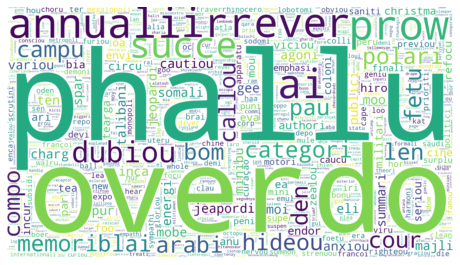

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,8])
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
 #use tfidfvectorizer to get word count matrix for all the samples
stopwords = nltk.corpus.stopwords.words('english')
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)  #define stop words
 
title = df.title.str.lower()
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df =10**-3 ,analyzer = 'word', max_features=len(total_stemmed1), stop_words=my_stop_words,tokenizer=tokenize_stem, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(title)


In [18]:
#save to drive 
#pickle.dump(tfidf_matrix, open("drive/MyDrive/tfidf_matrix.pkl", "wb" )) #save
tfidf_matrix = pickle.load(open("drive/MyDrive/tfidf_matrix.pkl", "rb" )) #read
tfidf_matrix

<509236x1728 sparse matrix of type '<class 'numpy.float64'>'
	with 3499485 stored elements in Compressed Sparse Row format>

#Modeling


In [37]:
#split data into train and test set

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df["up_votes"], test_size=0.2, random_state=0)

Linear Regression


In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
print('MSE from linear regression:',metrics.mean_squared_error(y_test,prediction))

MSE from linear regression: 273556.5616070391


Lasso Regression

In [41]:

# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define model
model = LassoCV(alphas=(0.001, 0.005, 0.01, 0.05,0.1, 0.5, 1), cv=cv, n_jobs=-1)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.005000


In [42]:
#build the model using selected alpha
reg_best = Lasso(alpha = 0.005)
reg_best.fit(X_train, y_train)
pred=reg_best.predict(X_test)
print('MSE from LASSO regression:', metrics.mean_squared_error(y_test,pred))

MSE from LASSO regression: 273433.3521483962


XGBoost


In [96]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.1, 1],
        'max_depth': [5, 10],
        'min_child_weight': [1, 5],
       'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor( n_estimators = 20, 
                             reg_alpha=0.005,seed = 123)

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [97]:

hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 10.2min finished


{'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'objective': 'reg:squarederror'}

In [98]:
#build the model using selected hyper-parameters
xgb_model = XGBRegressor(
        objective = 'reg:squarederror',
        learning_rate = 0.1,
        max_depth = 10,
        min_child_weight = 5,
        reg_alpha=0.005,
        n_estimators = 20)
       
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print("MSE from XGboost: ", mse_xgb)

MSE from XGboost:  277977.1289195248


Use the three models to fit top upvotes (top 10 percentiles)

In [78]:
ind=df1.index.values.astype(int)
X_top=tfidf_matrix[ind,]
X_top.shape

(50841, 1728)

In [79]:
#linear regression
y_top=df1.up_votes
pred_top1 = lr.predict(X_top)
print('MSE from linear regression for top up votes:',metrics.mean_squared_error(y_top,pred_top1))

MSE from linear regression for top up votes: 2659482.440579352


In [80]:
#Lasso

pred_top2=reg_best.predict(X_top)
print('MSE from LASSO regression for top up votes:', metrics.mean_squared_error(y_top,pred_top2))

MSE from LASSO regression for top up votes: 2669540.7079376113


In [88]:
#XGBoost
y_top3 = xgb_model.predict(X_top)
print("MSE from XGboost: ", mean_squared_error(y_top, y_top3))

MSE from XGboost:  2730082.5447040317
